# 📈 Прогнозирование внесений в АДМ Газпромбанка

## 🏦 Контекст

У Газпромбанка есть сеть терминалов для приёма наличности — **АДМ (автоматизированные устройства)**. Эти устройства позволяют клиентам вносить наличные деньги с моментальным зачислением на расчётный счёт, снижая издержки и повышая безопасность операций.

Терминалы расположены в **Москве и Московской области**, и используются **исключительно для внесения наличных**.

## 🎯 Цель проекта

Заказчик хочет построить **комплексную ML-систему** для:

- Прогнозирования внесений в каждый АДМ
- Оптимизации логистики и затрат на обслуживание сети

На первом этапе необходимо:

1. **Построить модель**, предсказывающую сумму внесений в каждый АДМ **на каждый день на месяц вперёд**
2. **Разбить АДМ на кластеры** со схожими паттернами активности
3. **Обосновать принятые решения** в ходе построения модели
4. **Интерпретировать результаты** для заказчика

Дополнительно:
- **Дополнение датасета внешними признаками** (например, погода, праздники, день недели и пр.) будет преимуществом.

---

## 📦 Описание данных

Вам предоставлен датасет за период **с 1 сентября по 30 ноября 2022 года**, содержащий:

### 🗺️ Лист `TIDS` — информация о терминалах

| Колонка      | Описание                             |
|--------------|--------------------------------------|
| `TID`        | Уникальный идентификатор АДМ         |
| `longitude`  | Долгота                              |
| `latitude`   | Широта                               |

---

### 💰 Лист `Incomes` — данные о внесениях

- Столбец `TID`: идентификатор АДМ
- Остальные столбцы: суммы внесений **по дням** в каждом АДМ  
  *(с 2022-09-01 по 2022-11-30)*

---

## ✅ Задачи

1. Провести предварительный анализ и визуализацию данных
2. Разработать кластеризацию по паттернам внесений 
3. Построить модель краткосрочного прогноза (на 30 дней)
4. Интерпретировать результаты для бизнеса
5. Подготовить рекомендации по использованию модели

---

> 📌 **Примечание:** АДМ = Автоматизированное устройство для приема, проверки, пересчета и хранения наличных денег.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import BallTree
import folium
from folium.plugins import MarkerCluster
from sklearn.neighbors import BallTree
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import lightgbm as lgb
import pandas as pd
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import shap

 - Загрузка исходных данных Incomes

In [336]:
incomes_df = pd.read_csv("/Users/sergejsilantev/Desktop/Книга2.csv", sep=";", encoding="utf-8")

incomes_df.head()

TID  01.09.2022 00:00  2022-09-02 00:00:00  2022-09-03 00:00:00  \
0  406136             90000               105000                99000   
1  406139            103000               206000               168000   
2  406145            143000               136000               124000   
3  406148             50000                73000                53000   
4  406180             96000                82000                71000   

   2022-09-04 00:00:00  2022-09-05 00:00:00  2022-09-06 00:00:00  \
0               107000               110000                60000   
1               124000                78000               165000   
2               117000               123000               140000   
3                65000                75000               100000   
4                72000                86000                55000   

   2022-09-07 00:00:00  2022-09-08 00:00:00  2022-09-09 00:00:00  ...  \
0                75000                89000                95000  ...   
1               164000               174000                88000  ...   
2               139000               138000               118000  ...   
3                53000                52000                82000  ...   
4                55000                75000                75000  ...   

   2022-11-21 00:00:00  2022-11-22 00:00:00  2022-11-23 00:00:00  \
0                91000                78000                    0   
1               164000               153000               151000   
2               119000               100000               179000   
3                48000                55000                65000   
4                82000                56000                70000   

   2022-11-24 00:00:00  2022-11-25 00:00:00  2022-11-26 00:00:00  \
0               165000                    0               189000   
1               157000               206000               182000   
2               169000               118000               118000   
3                85000                95000                68000   
4                59000               105000                70000   

   2022-11-27 00:00:00  2022-11-28 00:00:00  2022-11-29 00:00:00  \
0               106000                94000                75000   
1               123000               138000               112000   
2               114000               128000               121000   
3                62000                    0               118000   
4                77000                87000                59000   

   30.11.2022 00:00  
0             74000  
1            179000  
2            124000  
3             70000  
4             55000  

[5 rows x 92 columns]

 - Загрузка исходных данных Tids

In [335]:
tids_df = pd.read_csv("/Users/sergejsilantev/Desktop/Книга1.csv", sep=";", encoding="utf-8")

tids_df.head()

TID    longitude     latitude
0  692835  37,64625714  55,74206233
1  698656  37,66613636  55,73123146
2  686168  37,67502704  55,72703138
3  679671  37,66970577  55,70682369
4  682180  37,59639925  55,71115078

- Преобразование в long-формат

In [43]:
incomes = incomes_df.melt(
    id_vars="TID",              
    var_name="date",            
    value_name="amount"         #
)

incomes_long.head()

TID              date  amount
0  406136  01.09.2022 00:00   90000
1  406139  01.09.2022 00:00  103000
2  406145  01.09.2022 00:00  143000
3  406148  01.09.2022 00:00   50000
4  406180  01.09.2022 00:00   96000

## 🧠 Exploratory Data Analysis (EDA)

Анализ географического распределения и активности устройств АДМ.  
Цель — выявить закономерности в размещении, плотности, доходности и изолированности терминалов для последующего моделирования и оптимизации логистики.

In [55]:
incomes["date"] = pd.to_datetime(incomes["date"])
print("Уникальных АДМ:", incomes["TID"].nunique())
print("Диапазон дат:", incomes["date"].min().date(), "–", incomes["date"].max().date())
print("Всего записей:", len(incomes))
incomes.describe()

Уникальных АДМ: 1630
Диапазон дат: 2022-01-09 – 2022-11-30
Всего записей: 148330


TID        amount
count  148330.000000  1.483300e+05
mean   642270.744172  5.627512e+04
std     37581.513746  4.750017e+04
min    406136.000000  0.000000e+00
25%    619681.000000  3.000000e+04
50%    635770.000000  5.000000e+04
75%    668645.000000  7.100000e+04
max    699664.000000  2.697000e+06

- Распределение внесений


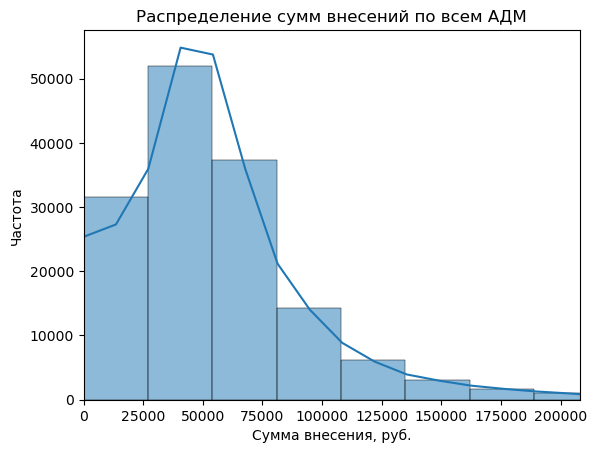

In [57]:
sns.histplot(incomes["amount"], bins=100, kde=True)
plt.title("Распределение сумм внесений по всем АДМ")
plt.xlabel("Сумма внесения, руб.")
plt.ylabel("Частота")
plt.xlim(0, incomes["amount"].quantile(0.99))
plt.show()

- Большинство внесений в устройства АДМ находятся в диапазоне до 50–60 тысяч рублей — это значит, что чаще всего клиенты вносят относительно небольшие суммы. Более крупные внесения (от 100 тысяч и выше) встречаются намного реже. Распределение сильно скошено вправо, что говорит о наличии редких, но очень больших операций. Это важно учитывать при моделировании и планировании обслуживания: стоит обратить внимание на часто встречающиеся суммы, но не забывать и про редкие всплески.

- Активность по дням недели

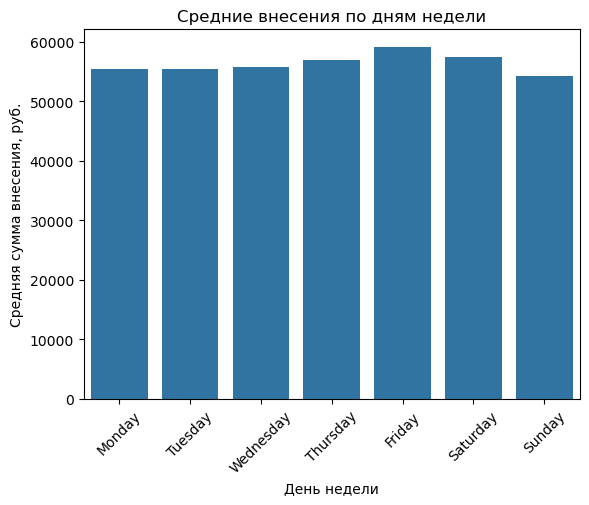

In [59]:
incomes["weekday"] = incomes["date"].dt.day_name()
weekday_avg = incomes.groupby("weekday")["amount"].mean().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

sns.barplot(x=weekday_avg.index, y=weekday_avg.values)
plt.title("Средние внесения по дням недели")
plt.ylabel("Средняя сумма внесения, руб.")
plt.xlabel("День недели")
plt.xticks(rotation=45)
plt.show()

- График показывает, что наибольшие суммы внесений происходят в пятницу, а наименьшие — в воскресенье. В будние дни суммы внесений примерно одинаковые и стабильно выше, чем в выходные. Это говорит о том, что клиенты чаще вносят деньги в течение рабочей недели, особенно под конец — возможно, это связано с закрытием кассовых операций или подготовкой к выходным. В воскресенье активность заметно падает, что логично, учитывая снижение деловой активности в этот день.

- ТОП-10 и АнтиТОП-10 АДМ

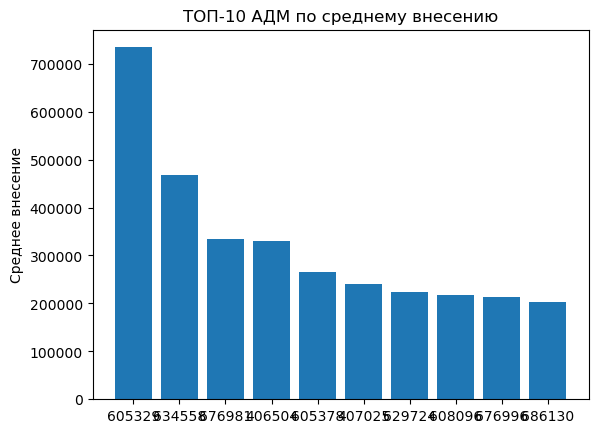

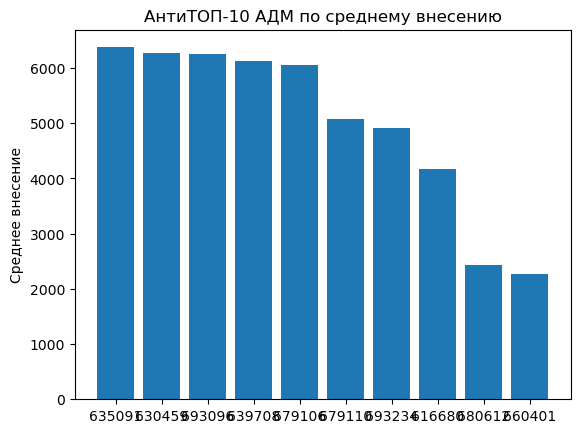

In [61]:
tid_avg = incomes.groupby("TID")["amount"].mean().sort_values(ascending=False)
top_10 = tid_avg.head(10)
bottom_10 = tid_avg.tail(10)

plt.bar(top_10.index.astype(str), top_10.values)
plt.title("ТОП-10 АДМ по среднему внесению")
plt.ylabel("Среднее внесение")
plt.show()

plt.bar(bottom_10.index.astype(str), bottom_10.values)
plt.title("АнтиТОП-10 АДМ по среднему внесению")
plt.ylabel("Среднее внесение")
plt.show()

- На графике видно, что одни устройства приносят очень много — до 700 тысяч рублей в день, а другие — всего 2–3 тысячи. Разница между лучшими и худшими терминалами огромная. Это говорит о том, что одни АДМ стоят в очень удачных местах с хорошим потоком клиентов, а другие почти не используются. Такие устройства с низкой активностью можно рассмотреть для перемещения или отключения, а самые прибыльные — обслуживать в первую очередь.

### 🌍 Анализ геоданных: расположение и активность АДМ

- Информация о DataFrame 

In [63]:
tids_df.info()

tids_df.head()

tids_df["longitude"] = tids_df["longitude"].str.replace(",", ".").astype(float)
tids_df["latitude"] = tids_df["latitude"].str.replace(",", ".").astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TID        1630 non-null   int64 
 1   longitude  1630 non-null   object
 2   latitude   1630 non-null   object
dtypes: int64(1), object(2)
memory usage: 38.3+ KB


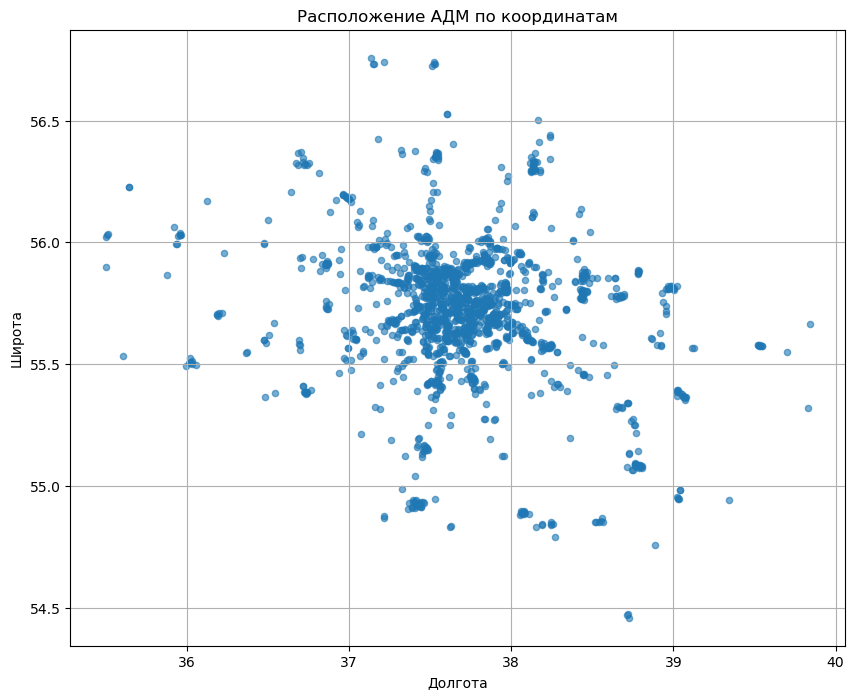

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(tids_df["longitude"], tids_df["latitude"], alpha=0.6, s=20)
plt.title("Расположение АДМ по координатам")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.grid(True)
plt.show()

- График показывает, что большинство АДМ сосредоточены в центре Москвы, а остальные — равномерно распределены по области. Также видно небольшое количество изолированных устройств на удалённых участках.

### 🗺 Визуализация устройств на карте с помощью Folium

Для анализа географического распределения АДМ мы используем библиотеку `folium`, которая позволяет строить интерактивные карты на Python.  
С её помощью можно наглядно отобразить расположение устройств, выявить скопления, изолированные точки и сопоставить географию с уровнем активности.  
Дополнительно применяется плагин `MarkerCluster`, который группирует близкорасположенные устройства, упрощая восприятие при большом количестве точек.

In [69]:
# Центр карты — средние координаты
map_center = [tids_df["latitude"].mean(), tids_df["longitude"].mean()]

# Создаем карту
adm_map = folium.Map(location=map_center, zoom_start=11)

# Кластеризация маркеров (чтобы не перегружать карту)
marker_cluster = MarkerCluster().add_to(adm_map)

# Добавим маркеры
for _, row in tids_df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"TID: {row['TID']}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(marker_cluster)

# Показываем карту
adm_map

### 📍 Поиск изолированных устройств (геоанализ)

Чтобы понять, какие АДМ расположены в отдалении от других, мы используем алгоритм `BallTree` с геодезической метрикой Haversine.  
Это позволяет определить количество ближайших соседей в радиусе 500 метров для каждого устройства.  
На основе этого мы выделим **изолированные АДМ** — те, у которых нет других терминалов поблизости.  
Такие устройства могут иметь особенности в работе и нуждаются в отдельной аналитике или оптимизации.

In [77]:
# 1. Переведём координаты в радианы
coords = np.radians(tids_df[["latitude", "longitude"]])

# 2. Строим BallTree с метрикой "haversine" (для геосферических расстояний)
tree = BallTree(coords, metric="haversine")

# 3. Радиус в радианах (500 метров ≈ 0.5 / 6371)
radius_km = 0.5
radius_rad = radius_km / 6371.0

# 4. Считаем количество соседей в радиусе
neighbors_count = tree.query_radius(coords, r=radius_rad, count_only=True)

# 5. Добавим в DataFrame
tids_df["neighbors_500m"] = neighbors_count
tids_df["is_isolated"] = tids_df["neighbors_500m"] <= 1  # 0 или только сам

# Посмотрим сколько изолированных
isolated_count = tids_df["is_isolated"].sum()
print(f"Изолированных устройств (≤1 сосед в радиусе 500м): {isolated_count}")

Изолированных устройств (≤1 сосед в радиусе 500м): 888


In [79]:
tids_df

TID  longitude   latitude  neighbors_500m  is_isolated
0     692835  37.646257  55.742062               1         True
1     698656  37.666136  55.731231               2        False
2     686168  37.675027  55.727031               1         True
3     679671  37.669706  55.706824               3        False
4     682180  37.596399  55.711151               3        False
...      ...        ...        ...             ...          ...
1625  607749  37.138157  56.757843               1         True
1626  699046  35.647877  56.226824               2        False
1627  637512  35.515147  56.032402               1         True
1628  680602  36.543716  55.380772               1         True
1629  698983  37.514735  56.725088               1         True

[1630 rows x 5 columns]

In [338]:
isolated_map = folium.Map(location=map_center, zoom_start=11)

for _, row in tids_df.iterrows():
    color = "red" if row["is_isolated"] else "green"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        popup=f"TID: {row['TID']}\nСоседей: {row['neighbors_500m']}",
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(isolated_map)

isolated_map

- На карте видно, что большинство АДМ сконцентрированы в центре Москвы, формируя плотную сеть (зелёные точки), тогда как на окраинах и в области много изолированных устройств (красные точки), у которых мало или вовсе нет соседей поблизости. Эти точки требуют отдельного внимания при планировании логистики и обслуживания.

- Напишем код который покажет приносят ли изолированные устройства меньше (или больше) денег

In [83]:
incomes_with_geo = incomes_long.merge(tids_df[["TID", "is_isolated"]], on="TID", how="left")

mean_income_by_tid = incomes_with_geo.groupby("TID")["amount"].mean().reset_index(name="mean_amount")

mean_income_by_tid = mean_income_by_tid.merge(tids_df[["TID", "is_isolated"]], on="TID", how="left")

group_summary = mean_income_by_tid.groupby("is_isolated")["mean_amount"].agg(["count", "mean", "median"]).reset_index()
print(group_summary)

   is_isolated  count          mean        median
0        False    742  55234.486538  48252.747253
1         True    888  57144.651520  50560.439560


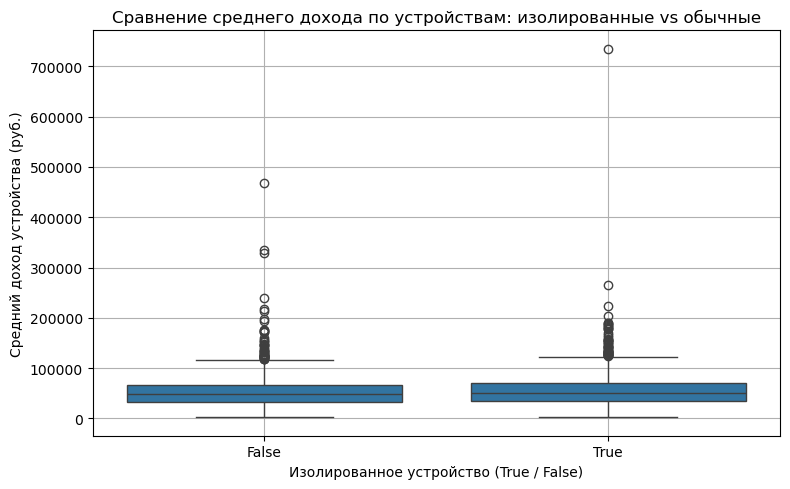

In [85]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="is_isolated", y="mean_amount", data=mean_income_by_tid)
plt.title("Сравнение среднего дохода по устройствам: изолированные vs обычные")
plt.xlabel("Изолированное устройство (True / False)")
plt.ylabel("Средний доход устройства (руб.)")
plt.grid(True)
plt.tight_layout()
plt.show()

- **Фактически, изолированные устройства приносят даже больше** — как по средней, так и по медианной сумме внесений.  
Это может быть связано с меньшей конкуренцией или удачно подобранной локацией.

- Выбираем топ-10 по среднему доходу

In [87]:
income_geo = incomes_long.merge(tids_df[["TID", "latitude", "longitude"]], on="TID", how="left")

tid_avg_income = (
    income_geo.groupby(["TID", "latitude", "longitude"])["amount"]
    .mean()
    .reset_index(name="mean_amount")
)

In [93]:
top10_income = tid_avg_income.sort_values("mean_amount", ascending=False).head(10)
# Центр карты по средним координатам топ-10
map_center = [top10_income["latitude"].mean(), top10_income["longitude"].mean()]
top10_map = folium.Map(location=map_center, zoom_start=12)

# Добавляем маркеры и подписи TID
for i, row in top10_income.iterrows():
    # Маркер со всплывающей информацией
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=(f"<b>🏷️ TID:</b> {row['TID']}<br>"
               f"<b>💰 Средний доход:</b> {row['mean_amount']:.0f} руб."),
        icon=folium.Icon(color="darkred", icon="star")
    ).add_to(top10_map)

    # Подпись с номером TID рядом с маркером
    folium.map.Marker(
        [row["latitude"], row["longitude"]],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12px; color: black;"><b>{row['TID']}</b></div>"""
        )
    ).add_to(top10_map)

# Показываем карту
top10_map

- На карте показаны самые прибыльные устройства, и, скорее всего, они приносят высокий доход благодаря удачному расположению — рядом с торговыми центрами, рынками, бизнес-зонами или транспортными узлами. Такие места обеспечивают постоянный поток клиентов, в том числе предпринимателей и компаний, которые регулярно вносят крупные суммы. Кроме того, часть устройств стоит там, где нет конкурентов поблизости, поэтому они обслуживают весь спрос в районе.

-  Выбираем 10 наименее прибыльных устройств

In [91]:
# Выбираем 10 наименее прибыльных устройств
bottom10_income = tid_avg_income.sort_values("mean_amount", ascending=True).head(10)

# Центр карты по координатам этих устройств
map_center = [bottom10_income["latitude"].mean(), bottom10_income["longitude"].mean()]
bottom10_map = folium.Map(location=map_center, zoom_start=12)

# Добавляем маркеры и подписи
for _, row in bottom10_income.iterrows():
    # Маркер со всплывающим окном
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=(f"<b>🏷️ TID:</b> {row['TID']}<br>"
               f"<b>💰 Средний доход:</b> {row['mean_amount']:.0f} руб."),
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(bottom10_map)

    # Подпись с номером TID рядом
    folium.Marker(
        [row["latitude"], row["longitude"]],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12px; color: black;"><b>{row['TID']}</b></div>"""
        )
    ).add_to(bottom10_map)

# Отображаем карту
bottom10_map

- Несмотря на ожидания, большинство наименее доходных устройств расположены не на окраинах, а внутри Москвы и ближнего Подмосковья.  
Это говорит о том, что даже в городских зонах терминалы могут показывать низкую эффективность — если они установлены в малолюдных местах, имеют ограниченный доступ или конкурируют с соседними АДМ.  
Такие точки стоит дополнительно проанализировать: возможно, их стоит переместить или изменить условия размещения.

### 🗓 Гипотеза 1: В пятницу вносят больше, чем в другие будние дни

Компании и индивидуальные предприниматели чаще всего вносят деньги в пятницу, чтобы закрыть кассовую неделю перед выходными.  
Предполагается, что **средний и медианный объём внесений в пятницу выше**, чем в остальные будни (с понедельника по четверг).


In [95]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
weekday_data = incomes[incomes["weekday"].isin(weekdays)]

weekday_summary = (
    weekday_data.groupby("weekday")["amount"]
    .agg(operations="count", mean_amount="mean", median_amount="median")
    .reset_index()
    .sort_values("mean_amount", ascending=False)
)

# Вывод таблицы
print(weekday_summary)

     weekday  operations   mean_amount  median_amount
0     Friday       21190  59109.957527        52000.0
2   Thursday       19560  56950.357873        50000.0
4  Wednesday       21190  55696.743747        49000.0
1     Monday       21190  55447.144880        48000.0
3    Tuesday       21190  55372.487022        48000.0


### 📊 Вывод по данным:

- **Пятница** действительно лидирует по:
  - **Среднему внесению**: ~59 110 руб.
  - **Медианному внесению**: ~52 000 руб.
- Остальные будни отстают на 2–5 тыс. руб.
- Количество операций по будням одинаковое (21190), что связано с равномерным покрытием дат в выборке.

✅ **Гипотеза подтверждается**: в пятницу действительно вносят больше, чем в другие будни.

### 🗓 Гипотеза 2: В конце месяца сумма внесений выше, чем в начале

**Ожидание:** в последние дни месяца (26–31 числа) компании чаще вносят деньги — закрывают отчётный период, платят зарплаты и т.д.  
Поэтому средняя сумма внесений в эти дни должна быть **выше**, чем в начале месяца (1–5 числа).


In [97]:
incomes["date"] = pd.to_datetime(incomes["date"])

incomes["day"] = incomes["date"].dt.day

incomes["month_period"] = incomes["day"].apply(
    lambda x: "start" if x <= 5 else ("end" if x >= 26 else "middle")
)

start_end = incomes[incomes["month_period"].isin(["start", "end"])]

summary = (
    start_end.groupby("month_period")["amount"]
    .agg(operations="count", mean_amount="mean", median_amount="median")
    .reset_index()
    .sort_values("mean_amount", ascending=False)
)

print(summary)

  month_period  operations   mean_amount  median_amount
1        start       22820  57565.074496        50000.0
0          end       26080  55979.294479        49000.0


### 📊 Вывод по данным:

📉 **Гипотеза не подтвердилась**:  
Средняя и медианная сумма внесений в **конце месяца** оказалась **ниже**, чем в начале.  
Также наблюдается немного больше операций в конце, но суммы меньше.

---

🧠 Возможные причины:
- В начале месяца вносят крупные суммы на старте оборота
- Конец месяца используется для частичных оплат или остатков

### 📆 Гипотеза 3: Самый активный день месяца — 1-е число

**Ожидание:** В первый день месяца компании и клиенты чаще вносят наличные — для оплаты аренды, зарплат, налогов и других регулярных обязательств.


In [99]:
incomes["date"] = pd.to_datetime(incomes["date"])

incomes["day"] = incomes["date"].dt.day

day_summary = (
    incomes.groupby("day")["amount"]
    .agg(operations="count", total_amount="sum", mean_amount="mean")
    .reset_index()
    .sort_values("total_amount", ascending=False)
)

print(day_summary.head())

day_1 = day_summary[day_summary["day"] == 1]
print("\n📅 Показатели за 1-е число месяца:")
print(day_1)

    day  operations  total_amount   mean_amount
8     9        6520     371844000  57031.288344
2     3        4890     288956000  59091.206544
14   15        4890     285672000  58419.631902
1     2        4890     283798000  58036.400818
3     4        4890     281731000  57613.701431

📅 Показатели за 1-е число месяца:
   day  operations  total_amount   mean_amount
0    1        3260     185787000  56989.877301


### 📊 Вывод по данным:

Анализ показал, что **1-е число действительно входит в топ-5 самых активных дней месяца** по сумме внесений, но **не является абсолютным лидером**. Его опережают 2-е, 3-е и 15-е числа. Разница между ними небольшая (~1–2 млн руб).

✅ **Гипотеза частично подтверждается**: 1-е число — один из пиков активности, но не единственный.

In [101]:
incomes_long

TID              date  amount
0       406136  01.09.2022 00:00   90000
1       406139  01.09.2022 00:00  103000
2       406145  01.09.2022 00:00  143000
3       406148  01.09.2022 00:00   50000
4       406180  01.09.2022 00:00   96000
...        ...               ...     ...
148325  699578  30.11.2022 00:00  120000
148326  699579  30.11.2022 00:00   94000
148327  699629  30.11.2022 00:00   50000
148328  699641  30.11.2022 00:00   45000
148329  699664  30.11.2022 00:00       0

[148330 rows x 3 columns]

### 🛠 Feature Engineering: создание новых признаков

На этом этапе мы формируем дополнительные признаки, которые помогут модели лучше понимать закономерности в данных.  
Мы используем как календарные признаки (день недели, выходной, начало/конец месяца), так и временные лаги, скользящие статистики и признаки активности.  
Это позволяет учесть сезонность, поведение клиентов и особенности работы каждого устройства во времени.

- Копируем данные и добавляем календарные признаки

In [103]:
# Копируем исходный DataFrame
df = incomes_long.copy()

# Убедимся, что дата в правильном формате
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# День недели (0 — понедельник, 6 — воскресенье)
df["day_of_week"] = df["date"].dt.weekday

# Является ли день выходным
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

# Начало и конец месяца
df["is_month_start"] = df["date"].dt.is_month_start.astype(int)
df["is_month_end"] = df["date"].dt.is_month_end.astype(int)

# День месяца, неделя года, номер месяца
df["day_of_month"] = df["date"].dt.day
df["week_of_year"] = df["date"].dt.isocalendar().week
df["month"] = df["date"].dt.month

-  Добавляем сезон года (зима, весна и т.д.)

In [105]:
# Простая функция для определения сезона
def get_season(month):
    return {
        12: "winter", 1: "winter", 2: "winter",
        3: "spring", 4: "spring", 5: "spring",
        6: "summer", 7: "summer", 8: "summer",
        9: "autumn", 10: "autumn", 11: "autumn"
    }[month]

# Применяем к каждому месяцу
df["season"] = df["month"].apply(get_season)

- Считаем лаги и скользящие статистики

In [107]:
# Сортируем данные по устройствам и дате
df = df.sort_values(["TID", "date"])

# Лаги за 7 предыдущих дней
for lag in range(1, 8):
    df[f"lag_{lag}"] = df.groupby("TID")["amount"].shift(lag)

# Скользящее среднее и стандартное отклонение за 3 дня
df["rolling_mean_3"] = df.groupby("TID")["amount"].transform(lambda x: x.shift(1).rolling(3).mean())
df["rolling_std_3"] = df.groupby("TID")["amount"].transform(lambda x: x.shift(1).rolling(3).std())

# Экспоненциально взвешенное среднее (больше вес недавним дням)
df["exp_moving_avg"] = df.groupby("TID")["amount"].transform(lambda x: x.shift(1).ewm(span=5).mean())

- Кумулятивные показатели (нарастающим итогом)

In [109]:
df["cumulative_sum"] = df.groupby("TID")["amount"].cumsum()
df["cumulative_count"] = df.groupby("TID").cumcount()

- Считаем дни с последнего внесения

In [111]:
def days_since_last_deposit(x):
    last_day = None
    result = []
    for date, amt in zip(x["date"], x["amount"]):
        if amt > 0:
            last_day = date
            result.append(0)
        else:
            result.append((date - last_day).days if last_day else np.nan)
    return result

# Применяем к каждому устройству
df["days_since_last_deposit"] = df.groupby("TID").apply(days_since_last_deposit).explode().values

- Соединим наш основной df c гео.данными tids_df

In [118]:
tids_clean = tids_df.drop(columns=["is_isolated"])

df = df.merge(tids_clean, on="TID", how="left")

- Расстояние до центра Москвы

In [136]:
moscow_center = (55.751244, 37.618423)

df["distance_to_center"] = df.apply(
    lambda row: geodesic((row["latitude_x"], row["longitude_x"]), moscow_center).km,
    axis=1
)

KeyError: 'latitude_x'

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148330 entries, 0 to 148329
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TID                      148330 non-null  int64         
 1   date                     148330 non-null  datetime64[ns]
 2   amount                   148330 non-null  int64         
 3   day_of_week              148330 non-null  int64         
 4   is_weekend               148330 non-null  int64         
 5   is_month_start           148330 non-null  int64         
 6   is_month_end             148330 non-null  int64         
 7   day_of_month             148330 non-null  int64         
 8   week_of_year             148330 non-null  UInt32        
 9   month                    148330 non-null  int64         
 10  season                   148330 non-null  object        
 11  lag_1                    146700 non-null  float64       
 12  lag_2           

- Удаления всех дублирующихся (и ненужных) колонок после объединения:


In [140]:
df = df.drop(columns=[
    "longitude_x", "latitude_x", "neighbors_500m_x",
    "longitude_y", "latitude_y", "neighbors_500m_y",
    "longitude", "latitude", "neighbors_500m"
], errors="ignore")

## 📊 Описание признаков датасета после Feature Engineering

| Признак | Тип | Описание |
|--------|-----|----------|
| `TID` | int64 | Идентификатор АДМ (терминала) |
| `date` | datetime64[ns] | Дата операции |
| `amount` | int64 | Сумма внесений в АДМ в конкретную дату |
| `day_of_week` | int64 | День недели (0 — понедельник, 6 — воскресенье) |
| `is_weekend` | int64 | Является ли день выходным (1 — да, 0 — нет) |
| `is_month_start` | int64 | Является ли день началом месяца (1 — да, 0 — нет) |
| `is_month_end` | int64 | Является ли день концом месяца (1 — да, 0 — нет) |
| `day_of_month` | int64 | День месяца (1–31) |
| `week_of_year` | UInt32 | Номер недели в году |
| `month` | int64 | Номер месяца (1–12) |
| `season` | object | Сезон: `'autumn'`, `'winter'` и т.п. |
| `lag_1` – `lag_7` | float64 | Сумма внесений за 1–7 предыдущих дней (лаговые признаки) |
| `rolling_mean_3` | float64 | Скользящее среднее суммы за 3 последних дня |
| `rolling_std_3` | float64 | Скользящее стандартное отклонение за 3 дня |
| `exp_moving_avg` | float64 | Экспоненциальное сглаженное среднее суммы внесений |
| `cumulative_sum` | int64 | Накопленная сумма внесений в этом АДМ на текущую дату |
| `cumulative_count` | int64 | Общее количество дней с внесениями до текущей даты |
| `days_since_last_deposit` | object | Количество дней с момента последнего внесения |
| `distance_to_center` | float64 | Расстояние от АДМ до центра Москвы |
| `cluster_id` | category | Кластер, к которому отнесён АДМ на основе паттернов поведения |

> 📝 Некоторые признаки (например, `lag_1`–`lag_7`, `rolling_mean_3`, `exp_moving_avg`) могут иметь пропущенные значения в начале временного ряда.

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148330 entries, 0 to 148329
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TID                      148330 non-null  int64         
 1   date                     148330 non-null  datetime64[ns]
 2   amount                   148330 non-null  int64         
 3   day_of_week              148330 non-null  int64         
 4   is_weekend               148330 non-null  int64         
 5   is_month_start           148330 non-null  int64         
 6   is_month_end             148330 non-null  int64         
 7   day_of_month             148330 non-null  int64         
 8   week_of_year             148330 non-null  UInt32        
 9   month                    148330 non-null  int64         
 10  season                   148330 non-null  object        
 11  lag_1                    146700 non-null  float64       
 12  lag_2           

## 🧠 Построение моделей: кластеризация как подготовка к регрессии

Переходим к блоку построения моделей. Прежде чем приступить к обучению регрессионных моделей для прогнозирования сумм внесений, важно предварительно **разделить терминалы (АДМ) на группы** со схожим поведением. Это позволяет:

- Повысить точность прогнозов за счёт индивидуальных моделей под каждую группу
- Упростить интерпретацию поведения устройств и выявить типовые паттерны

### 🔢 Кластеризация АДМ по агрегированным статистикам

Для сегментации АДМ по активности выполнены следующие шаги:

1. **Агрегация данных по каждому терминалу**:
   - Рассчитаны статистики по внесениям: `mean`, `std`, `min`, `max`, `median`, доля нулевых дней (`zero_ratio`) и количество наблюдений (`count`)

2. **Масштабирование признаков**:
   - Использован `StandardScaler` для нормализации значений перед кластеризацией

3. **Кластеризация с помощью KMeans**:
   - Алгоритм `KMeans` (`n_clusters=4`, `random_state=42`) позволяет выделить группы устройств с разными паттернами

4. **Добавление кластеров в основной датасет**:
   - Каждому терминалу присвоен `cluster_id`, который будет использоваться при обучении регрессионных моделей

> Кластеры позволят обучать более адаптированные модели прогнозирования, учитывающие особенности поведения разных типов АДМ.

In [130]:
# 1. Агрегация по устройствам
agg_features = df.groupby("TID")["amount"].agg([
    "mean", "std", "min", "max", "median",
    lambda x: (x == 0).mean(), "count"
]).reset_index()

# 2. Переименование столбцов
agg_features.columns = ["TID", "mean", "std", "min", "max", "median", "zero_ratio", "count"]

# 3. Масштабирование признаков
X = agg_features.drop(columns="TID")
X_scaled = StandardScaler().fit_transform(X)

# 4. Кластеризация (KMeans)
agg_features["cluster_id"] = KMeans(n_clusters=4, random_state=42).fit_predict(X_scaled)

# 5. Присоединение кластеров обратно к основному df
df = df.merge(agg_features[["TID", "cluster_id"]], on="TID", how="left")
df["cluster_id"] = df["cluster_id"].astype("category")

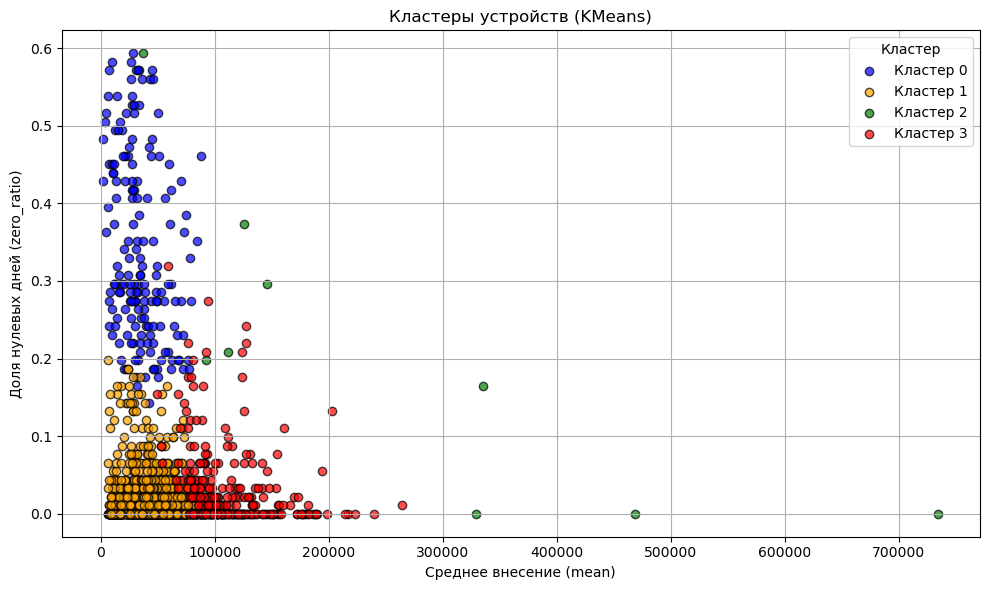

In [454]:
cluster_colors = {
    0: "blue",    
    1: "orange",   
    2: "green",   
    3: "red"      
}

x_col = "mean"
y_col = "zero_ratio"

plt.figure(figsize=(10, 6))

for cluster_id in sorted(agg_features["cluster_id"].unique()):
    cluster_data = agg_features[agg_features["cluster_id"] == cluster_id]
    plt.scatter(
        cluster_data[x_col],
        cluster_data[y_col],
        color=cluster_colors[int(cluster_id)],
        label=f"Кластер {cluster_id}",
        alpha=0.7,
        edgecolor="k"
    )

plt.xlabel("Среднее внесение (mean)")
plt.ylabel("Доля нулевых дней (zero_ratio)")
plt.title("Кластеры устройств (KMeans)")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧠 Интерпретация кластеров устройств

Кластеры были сформированы на основе поведенческих признаков устройств (средний доход, стабильность, простои и т.д.).  
Вот как можно интерпретировать полученные группы:

- 🔵 **Кластер 0:** Устройства со стабильными и высокими внесениями
- 🟠 **Кластер 1:** Часто простаивают (высокий `zero_ratio`)
- 🟢 **Кластер 2:** Маленькие, но регулярные суммы
- 🔴 **Кластер 3:** Очень редкие или нестабильные операции


In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148330 entries, 0 to 148329
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TID                      148330 non-null  int64         
 1   date                     148330 non-null  datetime64[ns]
 2   amount                   148330 non-null  int64         
 3   day_of_week              148330 non-null  int64         
 4   is_weekend               148330 non-null  int64         
 5   is_month_start           148330 non-null  int64         
 6   is_month_end             148330 non-null  int64         
 7   day_of_month             148330 non-null  int64         
 8   week_of_year             148330 non-null  UInt32        
 9   month                    148330 non-null  int64         
 10  season                   148330 non-null  object        
 11  lag_1                    146700 non-null  float64       
 12  lag_2           

#### ✅ Baseline-модель: LightGBM Regressor

-  Разделение на train/valid по дате

In [346]:
train_df = df[df["date"] < "2022-11-01"]
valid_df = df[(df["date"] >= "2022-11-01") & (df["date"] < "2022-12-01")]

-  Выбор признаков и целевой переменной

In [350]:
feature_cols = [
    "day_of_week", "is_weekend", "is_month_start", "is_month_end",
    "day_of_month", "week_of_year", "month",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "rolling_mean_3", "rolling_std_3", "exp_moving_avg",
    "cumulative_sum", "cumulative_count", "days_since_last_deposit",
    "season", "cluster_id"
]
target = "amount"

X_train = train_df[feature_cols].copy()
y_train = train_df[target]
X_valid = valid_df[feature_cols].copy()
y_valid = valid_df[target]

-  Преобразование типов и обработка пропусков


In [352]:
cat_features = ["season", "cluster_id"]

# Категориальные признаки → category
for col in cat_features:
    X_train[col] = X_train[col].astype("category")
    X_valid[col] = X_valid[col].astype("category")

# Числовое преобразование признака "days_since_last_deposit"
X_train["days_since_last_deposit"] = pd.to_numeric(X_train["days_since_last_deposit"], errors="coerce")
X_valid["days_since_last_deposit"] = pd.to_numeric(X_valid["days_since_last_deposit"], errors="coerce")

# Заполнение пропусков нулями
X_train.fillna(0, inplace=True)
X_valid.fillna(0, inplace=True)

- Обучение LightGBM модели

In [356]:
model = LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="mae",
    categorical_feature=cat_features,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 99430, number of used features: 22
[LightGBM] [Info] Start training from score 56820.094539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 14482.2	valid_0's l2: 6.72602e+08


LGBMRegressor(learning_rate=0.05, n_estimators=1000, objective='regression',
              random_state=42)

-  Предсказание и оценка качества

In [466]:
y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)

print(f"📉 MAE на валидации (в рублях): {mae:,.0f}")

📉 MAE на валидации (в рублях): 14,048


-  Грфик фактические vs прогнозируемые суммы по кластерам

/var/folders/gy/3bzj9cf508jfszj421gpvb300000gn/T/ipykernel_50122/2742175530.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/Users/sergejsilantev/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


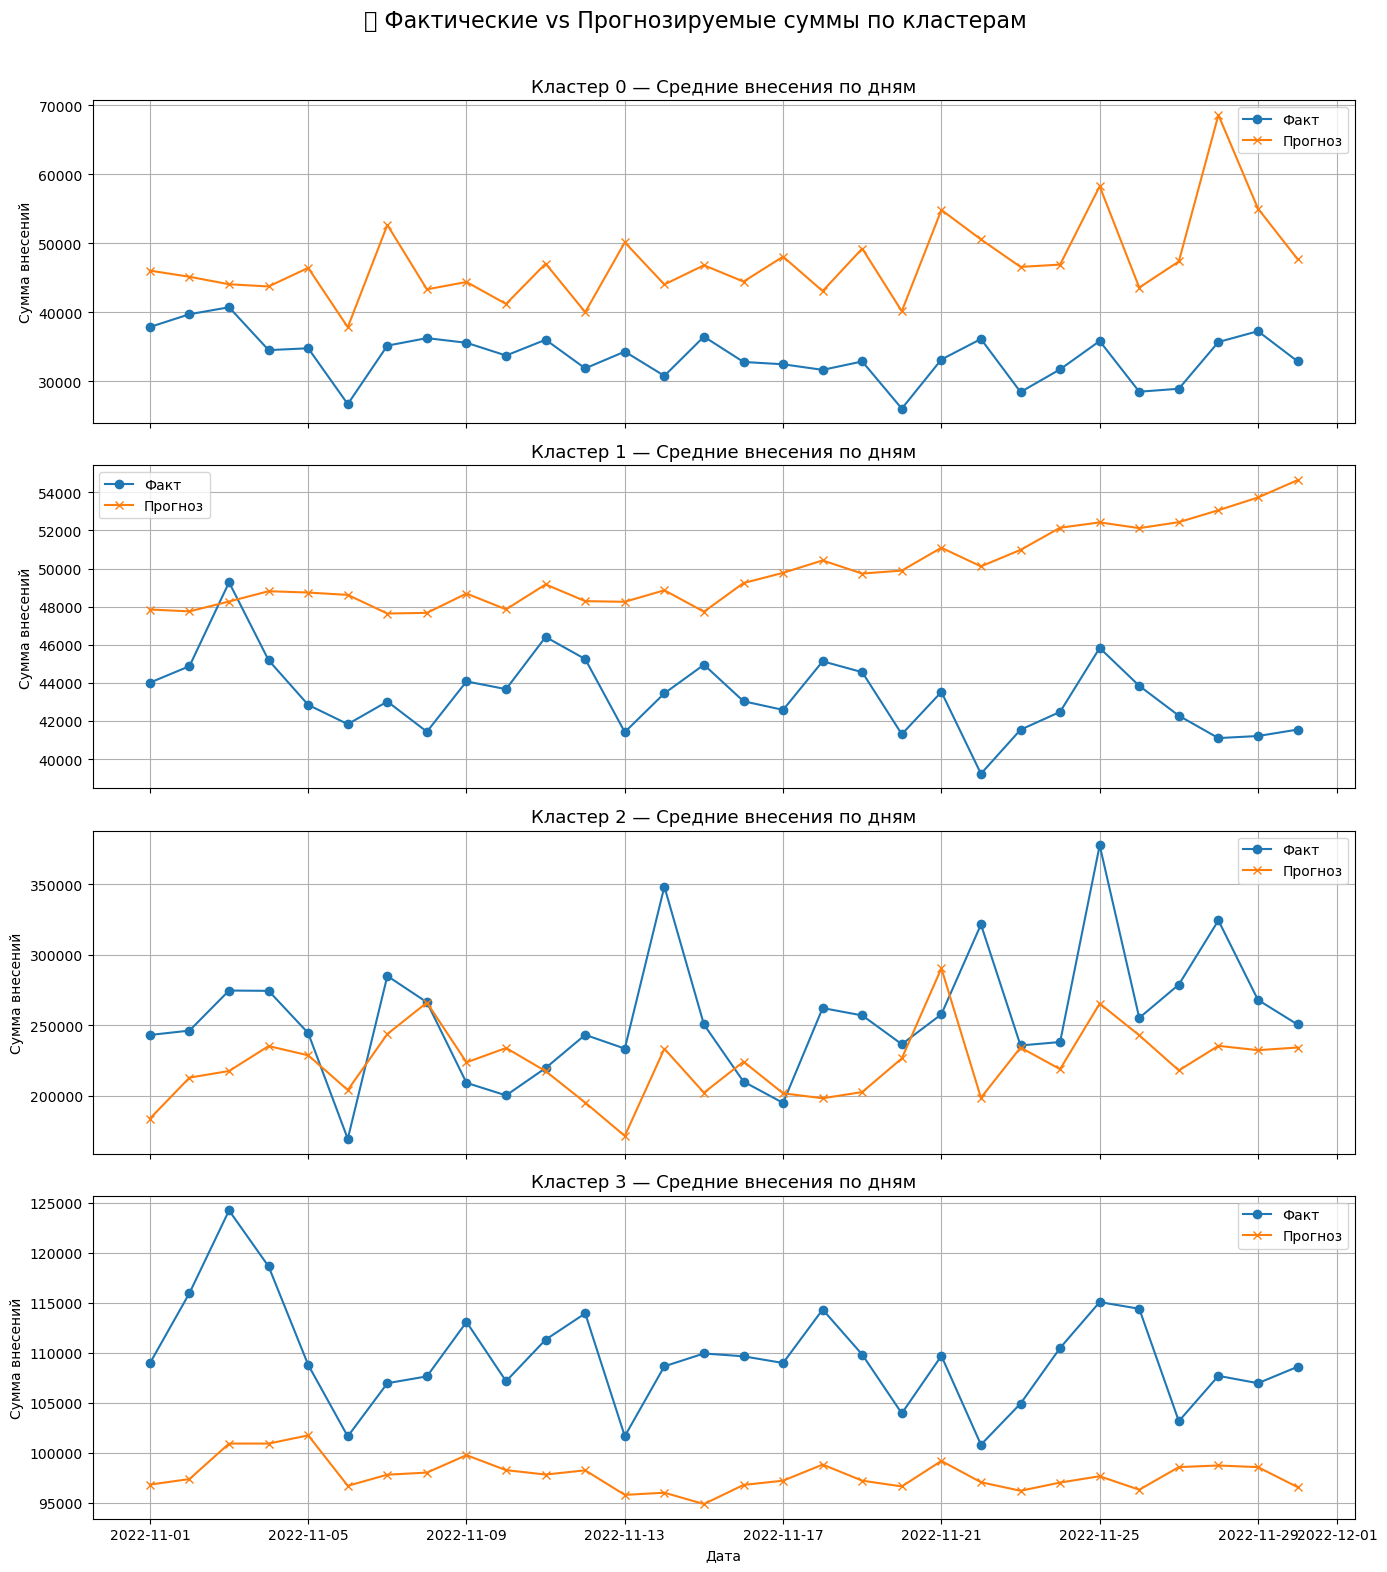

In [370]:

valid_df = valid_df.copy()
valid_df["y_pred"] = y_pred


valid_df["cluster_id"] = valid_df["cluster_id"].astype("category")


n_clusters = valid_df["cluster_id"].nunique()
fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 4 * n_clusters), sharex=True)

for i, cluster in enumerate(sorted(valid_df["cluster_id"].unique())):
    ax = axes[i]
    cluster_data = valid_df[valid_df["cluster_id"] == cluster]
    
    daily_actual = cluster_data.groupby("date")["amount"].mean()
    daily_pred = cluster_data.groupby("date")["y_pred"].mean()

    ax.plot(daily_actual.index, daily_actual.values, label="Факт", marker="o")
    ax.plot(daily_pred.index, daily_pred.values, label="Прогноз", marker="x")

    ax.set_title(f"Кластер {cluster} — Средние внесения по дням", fontsize=13)
    ax.set_ylabel("Сумма внесений")
    ax.legend()
    ax.grid(True)

plt.xlabel("Дата")
plt.suptitle(" Фактические vs Прогнозируемые суммы по кластерам", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

##### 📉 Вывод по графикам предсказаний модели

Модель показывает стабильное поведение, однако наблюдаются отклонения:

- В **кластерах 0 и 1** модель систематически **переоценивает суммы внесений**, особенно ближе к концу месяца.
- В **кластерах 2 и 3** модель заметно **занижает пики активности** и не улавливает резкие колебания — вероятно, из-за сглаженных признаков и отсутствия внешних факторов (например, праздников, событий или погодных условий).
- Во всех кластерах модель лучше справляется с **общим уровнем активности**, чем с **краткосрочной волатильностью**.

##### ✅ Резюме:
Текущая модель даёт **разумный baseline**, но требует улучшений:
- учёт дополнительных факторов (внешние события, сезонность, и пр.),
- возможное обучение отдельных моделей для каждого кластера,
- генерация фичей на будущее — для построения реального прогноза на месяц вперёд.

## 🔁 Пошаговое прогнозирование на декабрь 2022 года

На данном этапе мы переходим от построения baseline-модели к **реальному прогнозу на будущее**, то есть — **на каждый день декабря 2022 года для каждого АДМ**.

### Зачем нужен этот шаг?

- Мы хотим смоделировать поведение сети терминалов без знания фактических значений, как это будет в реальной эксплуатации.
- Для этого необходимо каждый день использовать предсказания предыдущих дней, чтобы корректно построить временные признаки (лаги, скользящие средние и пр.).
- Такой подход имитирует работу модели **в проде**, где история постоянно обновляется и используется "на лету".

### Что делает код ниже:

1. Для каждого терминала (`TID`) и каждой даты в декабре:
   - Строятся календарные и временные признаки (включая лаги и rolling-метрики)
   - Используется обученная модель для предсказания суммы внесений
   - Прогноз добавляется в "историю", чтобы влиять на расчёт признаков следующих дней

2. В результате формируется датафрейм `forecast_df`, содержащий:
   - `TID`, `date`, `predicted_amount`  
   То есть — **ежедневный прогноз по каждому устройству** на весь декабрь.

> 💡 Такой пошаговый автопрогноз позволяет учесть каскадные эффекты (например, если один день имеет нулевой прогноз, это повлияет на лаги и скользящие значения в будущем).

- Настройка периода прогноза и признаков

In [384]:
# Настройки прогноза
last_known_date = pd.to_datetime("2022-11-30")
future_dates = pd.date_range(start="2022-12-01", periods=30)
all_tids = df["TID"].unique()

# Отбор исторических данных
history_df = df[df["date"] <= last_known_date].copy()
future_predictions = []

# Фичи, используемые моделью
feature_cols = [
    "day_of_week", "is_weekend", "is_month_start", "is_month_end",
    "day_of_month", "week_of_year", "month",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "rolling_mean_3", "rolling_std_3", "exp_moving_avg",
    "cumulative_sum", "cumulative_count", "days_since_last_deposit",
    "season", "cluster_id"
]

# Маппинг месяца на сезон
season_map = {
    12: "winter", 1: "winter", 2: "winter",
    3: "spring", 4: "spring", 5: "spring",
    6: "summer", 7: "summer", 8: "summer",
    9: "autumn", 10: "autumn", 11: "autumn"
}

- Пошаговый прогноз по каждому терминалу

In [ ]:
for tid in tqdm(all_tids):
    # Исторические данные по терминалу
    tid_hist = history_df[history_df["TID"] == tid].sort_values("date").copy()
    cluster_id = tid_hist["cluster_id"].iloc[-1]
    
    values = list(tid_hist["amount"].values)
    dates = list(tid_hist["date"].values)

    for date in future_dates:
        # Календарные и базовые признаки
        row = {
            "TID": tid,
            "date": date,
            "day_of_week": date.weekday(),
            "is_weekend": int(date.weekday() >= 5),
            "is_month_start": int(date.is_month_start),
            "is_month_end": int(date.is_month_end),
            "day_of_month": date.day,
            "week_of_year": date.isocalendar().week,
            "month": date.month,
            "season": season_map[date.month],
            "cluster_id": cluster_id,
        }

        # Лаговые признаки
        for i in range(1, 8):
            row[f"lag_{i}"] = values[-i] if len(values) >= i else 0

        # Скользящие статистики
        last_vals = values[-3:] if len(values) >= 3 else [0] * 3
        row["rolling_mean_3"] = np.mean(last_vals)
        row["rolling_std_3"] = np.std(last_vals)
        row["exp_moving_avg"] = pd.Series(values).ewm(span=5).mean().iloc[-1] if values else 0

        # Кумулятивные признаки
        row["cumulative_sum"] = np.sum(values)
        row["cumulative_count"] = len(values)

        # Дней с последнего внесения
        last_nonzero_dates = [d for v, d in zip(values, dates) if v > 0]
        row["days_since_last_deposit"] = (date - last_nonzero_dates[-1]).days if last_nonzero_dates else 999

        # Приведение типов и заполнение
        row_df = pd.DataFrame([row])
        row_df["season"] = row_df["season"].astype("category")
        row_df["cluster_id"] = row_df["cluster_id"].astype("category")
        row_df["days_since_last_deposit"] = pd.to_numeric(row_df["days_since_last_deposit"], errors="coerce")
        row_df.fillna(0, inplace=True)

        # Прогноз
        pred = model.predict(row_df[feature_cols])[0]

        # Сохраняем результат
        future_predictions.append({
            "TID": tid,
            "date": date,
            "predicted_amount": pred
        })

        # Обновление истории
        values.append(pred)
        dates.append(date)

 83%|████████████████████████████████▎      | 1352/1630 [02:24<00:28,  9.73it/s]

- Сбор финального прогноза

In [443]:
forecast_df = pd.DataFrame(future_predictions)
forecast_df.head()

TID       date  predicted_amount
0  406136 2022-12-01      13494.684548
1  406136 2022-12-02      20198.516040
2  406136 2022-12-03      13453.687683
3  406136 2022-12-04      41358.525628
4  406136 2022-12-05      57544.135390

- График прогноза по кластерам


/var/folders/gy/3bzj9cf508jfszj421gpvb300000gn/T/ipykernel_50122/3022046005.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/sergejsilantev/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


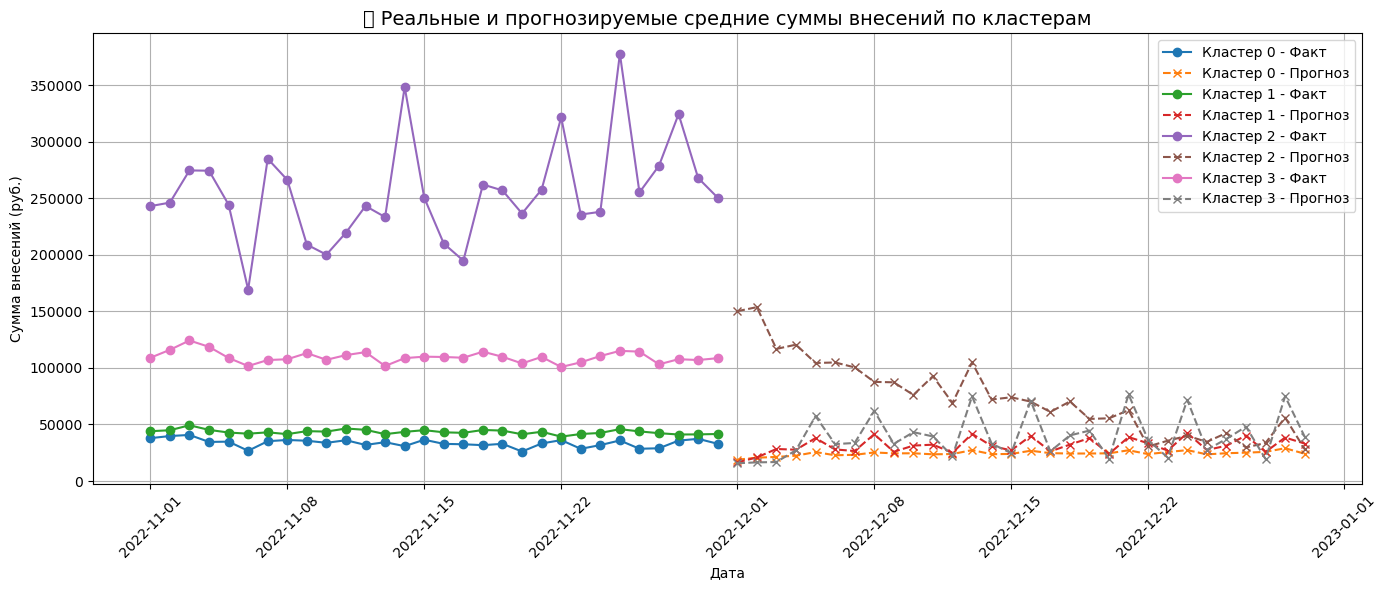

In [463]:
actual_df = df[df["date"] >= "2022-11-01"].copy()  # берём последний месяц
actual_df = actual_df[["TID", "date", "amount", "cluster_id"]]
actual_df["source"] = "actual"
actual_df.rename(columns={"amount": "value"}, inplace=True)

forecast_df["source"] = "forecast"
forecast_df.rename(columns={"predicted_amount": "value"}, inplace=True)


combined = pd.concat([
    actual_df[["TID", "date", "value", "cluster_id", "source"]],
    forecast_df[["TID", "date", "value", "cluster_id", "source"]]
])


cluster_daily = combined.groupby(["date", "cluster_id", "source"])["value"].mean().reset_index()

plt.figure(figsize=(14, 6))
for cluster in sorted(cluster_daily["cluster_id"].unique()):
    cluster_actual = cluster_daily[(cluster_daily["cluster_id"] == cluster) & (cluster_daily["source"] == "actual")]
    cluster_forecast = cluster_daily[(cluster_daily["cluster_id"] == cluster) & (cluster_daily["source"] == "forecast")]

    plt.plot(cluster_actual["date"], cluster_actual["value"], label=f"Кластер {cluster} - Факт", linestyle="-", marker="o")
    plt.plot(cluster_forecast["date"], cluster_forecast["value"], label=f"Кластер {cluster} - Прогноз", linestyle="--", marker="x")

plt.title("Реальные и прогнозируемые средние суммы внесений по кластерам", fontsize=14)
plt.xlabel("Дата")
plt.ylabel("Сумма внесений (руб.)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 📉 Вывод по графику прогноза по кластерам

Модель демонстрирует адекватное понимание **общего уровня активности**, но:

-  **Систематически занижает** прогнозы по всем кластерам на декабрь
-  **Не улавливает резкие пики и колебания** активности
-  Лучше справляется со стабильными кластерами, хуже — с волатильными

> 💡 Вывод: модели не хватает информации о будущих событиях — она опирается только на прошлые значения и выдает сглаженные прогнозы без учёта возможных всплесков.

## 🚀 Модель с прогнозом на 30 дней вперёд (Multi-output LightGBM)

Предыдущая версия модели делала автопрогноз на каждый следующий день, последовательно используя предыдущие предсказания. Такой подход приводил к накапливающимся ошибкам и "сползанию" прогноза вниз.

🔁 В этом блоке реализован **альтернативный подход — обучение отдельных моделей LightGBM для каждого горизонта (t+1, t+2, ..., t+30)**. Это называется multi-output стратегия.

### ✅ Почему этот подход лучше:

- Каждая модель обучается **непосредственно на соответствующем горизонте**, а не строится поверх цепочки из прошлых предсказаний
- Отсутствует накопление ошибок, присущее авто-рекурсивным методам
- Прогнозы становятся **более устойчивыми и приближенными к реальному поведению**
- Легче отследить качество по каждому горизонту и адаптировать стратегию под бизнес-задачи

### 📦 Что делает код:

1. **Создаёт 30 отдельных таргетов** — `amount` на t+1 до t+30
2. **Обучает 30 моделей LightGBM** — по одному для каждого горизонта
3. **Прогнозирует на основе данных за 30 ноября** на весь декабрь
4. **Строит сравнение по кластерам** — реальные vs прогнозные средние суммы внесений

> 📉 По сравнению с предыдущей моделью, этот подход даёт **более реалистичный, устойчивый и плавный прогноз**, особенно на длинном горизонте.

In [416]:
# : Подготовка df_multi с таргетами на t+1…t+30 
df_multi = df.sort_values(["TID", "date"]).copy()
for k in range(1, 31):
    df_multi[f"target_t_plus_{k}"] = df_multi.groupby("TID")["amount"].shift(-k)

df_multi = df_multi.dropna(subset=[f"target_t_plus_{k}" for k in range(1, 31)])

#  Обучение 30 моделей LightGBM 
feature_cols = [
    "day_of_week", "is_weekend", "is_month_start", "is_month_end",
    "day_of_month", "week_of_year", "month",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "rolling_mean_3", "rolling_std_3", "exp_moving_avg",
    "cumulative_sum", "cumulative_count", "days_since_last_deposit",
    "season", "cluster_id"
]

X = df_multi[feature_cols].copy()
X["season"] = X["season"].astype("category")
X["cluster_id"] = X["cluster_id"].astype("category")
X["days_since_last_deposit"] = pd.to_numeric(X["days_since_last_deposit"], errors="coerce")
X = X.fillna(0)

models = {}
for k in range(1, 31):
    y = df_multi[f"target_t_plus_{k}"]
    model = LGBMRegressor(
        objective="regression",
        learning_rate=0.05,
        num_leaves=31,
        n_estimators=200,
        random_state=42
    )
    model.fit(X, y, categorical_feature=["season", "cluster_id"])
    models[k] = model

# Прогноз на 30 дней вперёд 
last_day_df = df[df["date"] == "2022-11-30"].copy()
last_X = last_day_df[feature_cols].copy()
last_X["season"] = last_X["season"].astype("category")
last_X["cluster_id"] = last_X["cluster_id"].astype("category")
last_X["days_since_last_deposit"] = pd.to_numeric(last_X["days_since_last_deposit"], errors="coerce")
last_X = last_X.fillna(0)

multi_preds = []
for k in range(1, 31):
    preds = models[k].predict(last_X)
    multi_preds.append(pd.DataFrame({
        "TID": last_day_df["TID"].values,
        "date": pd.to_datetime("2022-11-30") + pd.Timedelta(days=k),
        "predicted_amount": preds,
        "horizon": k
    }))

forecast_multi_df = pd.concat(multi_preds, ignore_index=True)
forecast_multi_df = forecast_multi_df.sort_values(["TID", "date"])

#  Добавляем кластер к прогнозу 
forecast_multi_df = forecast_multi_df.merge(df[["TID", "cluster_id"]].drop_duplicates(), on="TID", how="left")
forecast_multi_df["cluster_id"] = forecast_multi_df["cluster_id"].astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 99430, number of used features: 22
[LightGBM] [Info] Start training from score 56765.714573
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 99430, number of used features: 22
[LightGBM] [Info] Start training from score 56741.064065
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

- Построение графиков по каждому кластеру

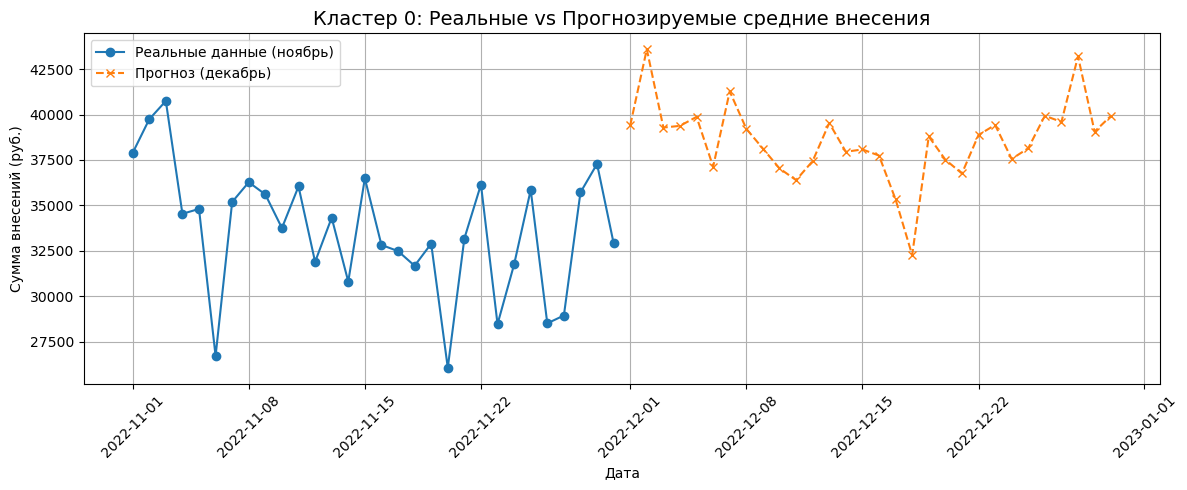

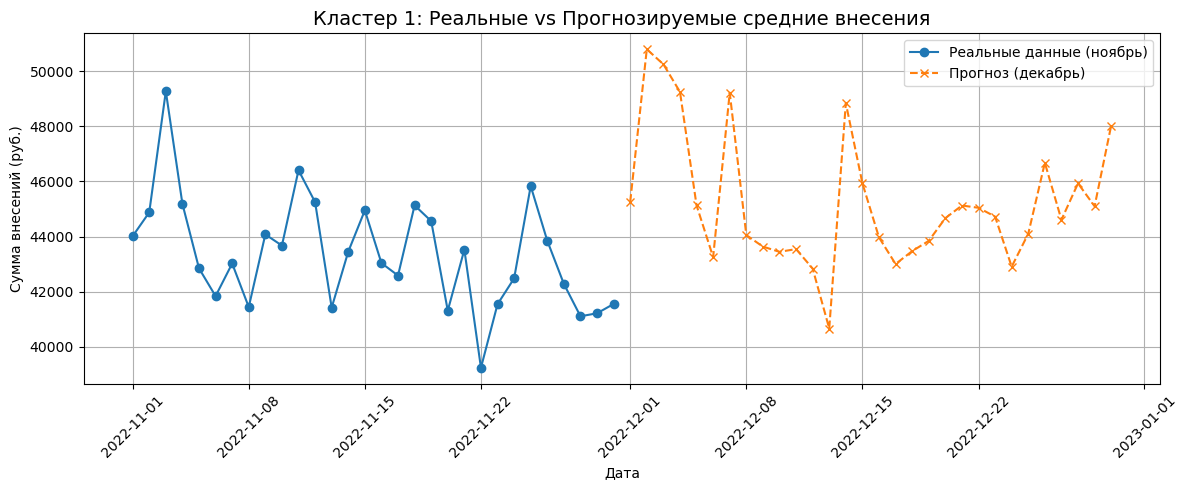

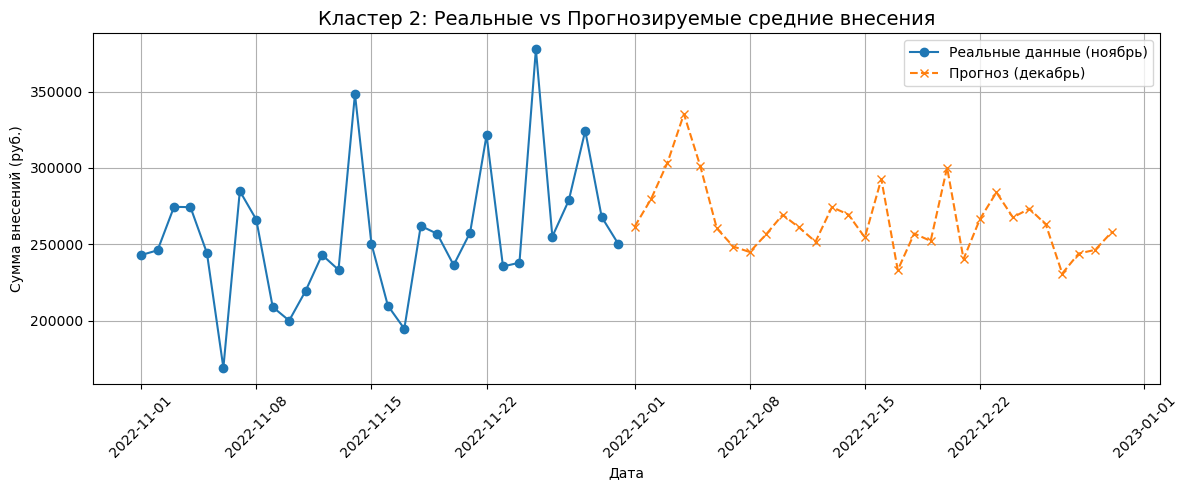

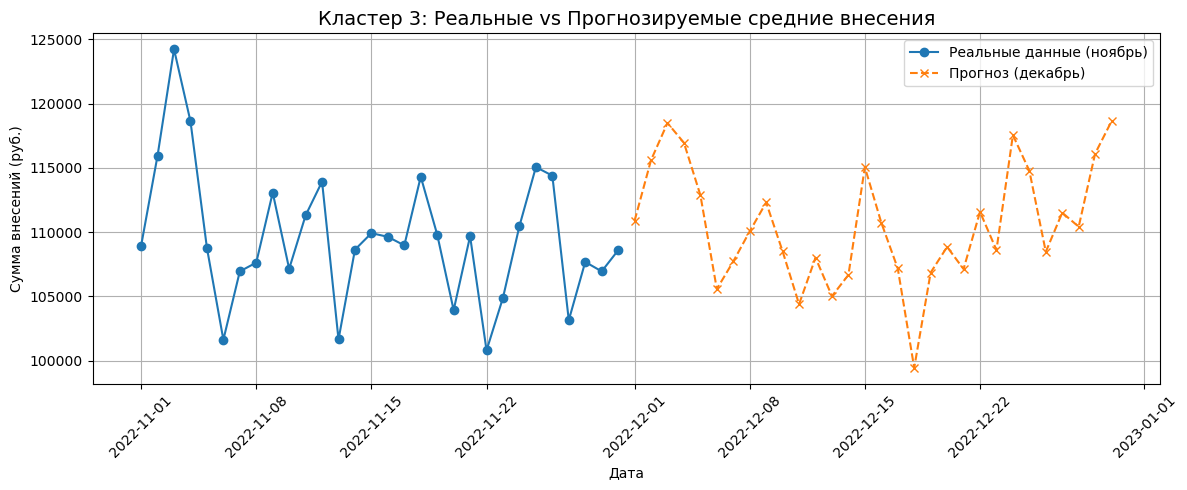

In [422]:

real_df = df[df["date"] >= "2022-11-01"].copy()
real_avg = real_df.groupby(["date", "cluster_id"])["amount"].mean().reset_index()

forecast_avg = forecast_multi_df.groupby(["date", "cluster_id"])["predicted_amount"].mean().reset_index()

for cluster in sorted(real_avg["cluster_id"].unique()):
    plt.figure(figsize=(12, 5))

    real = real_avg[real_avg["cluster_id"] == cluster]
    forecast = forecast_avg[forecast_avg["cluster_id"] == cluster]

    plt.plot(real["date"], real["amount"], label="Реальные данные (ноябрь)", color="tab:blue", marker="o")
    plt.plot(forecast["date"], forecast["predicted_amount"], label="Прогноз (декабрь)", color="tab:orange", linestyle="--", marker="x")

    plt.title(f"Кластер {cluster}: Реальные vs Прогнозируемые средние внесения", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Сумма внесений (руб.)")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 📊 Вывод по результатам модели (прогноз на 30 дней вперёд)

Модель показывает хорошие и стабильные результаты по всем кластерам. Вот коротко по каждому:

- **Кластер 0**  
  Прогнозы близки к реальным значениям. Модель сглаживает колебания и хорошо держит общий уровень.

- **Кластер 1**  
  В целом всё неплохо, но модель немного занижает прогнозы в середине декабря. Общий тренд сохранён.

- **Кластер 2**  
  Самый активный кластер. Модель справляется хорошо, предсказывает высокие значения, хоть и немного сглаживает пики.

- **Кластер 3**  
  Очень стабильный результат — модель повторяет реальное поведение, хорошо отражает умеренные колебания.

### ✅ Общий вывод:

- Прогноз получился **реалистичным и устойчивым**.
- В отличие от предыдущего подхода, **нет провалов вниз**, и модель не "съезжает" со временем.
- Немного сглажены резкие всплески — это можно улучшить с помощью дополнительных признаков (праздники, события и т.п.)

> 📌 Эта стратегия (отдельная модель на каждый день) даёт заметно **лучший результат**, особенно на длинной дистанции.

## 🧠 Анализ важности признаков модели

Чтобы не просто "верить" модели, а **понимать, как она принимает решения**, важно проанализировать, какие признаки влияют на итоговый прогноз сильнее всего.

### 🔍 Зачем это нужно:

- 💬 Показать заказчику, что модель основывается на логичных факторах (дни недели, история, сезонность и т.д.)
- 🛠 Помогает **дорабатывать модель**: убирать шумные признаки и усиливать полезные
- 📊 Используется для интерпретации: объяснить, почему терминал X получил прогноз Y

### 🧰 Что мы делаем:

1. **Смотрим встроенную важность признаков (gain/split)** из LightGBM — она показывает, какие фичи чаще всего используются деревьями и как сильно они влияют на качество модели.
2. **Используем SHAP** — это современный метод интерпретации моделей, который показывает:
   - как каждый признак **влияет на итоговое предсказание**
   - какие значения фич "толкают" результат вверх или вниз
   - можно объяснять как поведение всей модели, так и каждого конкретного предсказания

> 📌 Этот анализ делает модель более прозрачной, объяснимой и доверительной с точки зрения бизнеса.

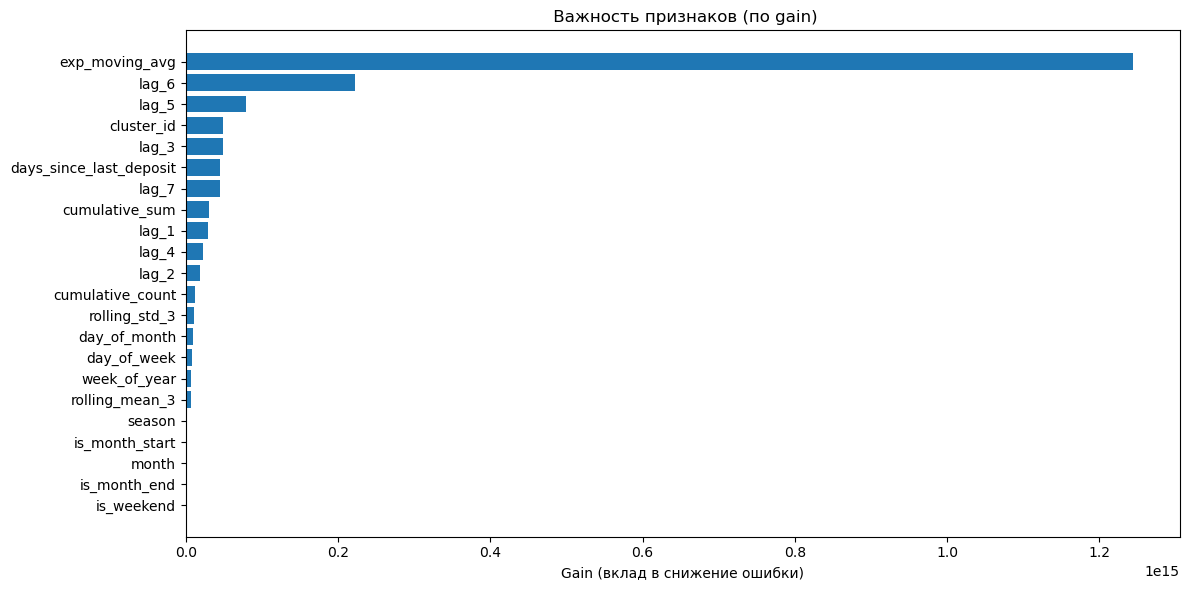

In [429]:
model = models[1]  

importance_df = pd.DataFrame({
    "feature": model.feature_name_,
    "gain": model.booster_.feature_importance(importance_type="gain"),
    "split": model.booster_.feature_importance(importance_type="split")
})

importance_df = importance_df.sort_values("gain", ascending=False)


plt.figure(figsize=(12, 6))
plt.barh(importance_df["feature"], importance_df["gain"])
plt.gca().invert_yaxis()
plt.title(" Важность признаков (по gain)")
plt.xlabel("Gain (вклад в снижение ошибки)")
plt.tight_layout()
plt.show()

In [433]:
import shap

model = models[1]

X_shap = df_multi[feature_cols].copy()
X_shap["season"] = X_shap["season"].astype("category")
X_shap["cluster_id"] = X_shap["cluster_id"].astype("category")
X_shap["days_since_last_deposit"] = pd.to_numeric(X_shap["days_since_last_deposit"], errors="coerce")
X_shap = X_shap.fillna(0)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

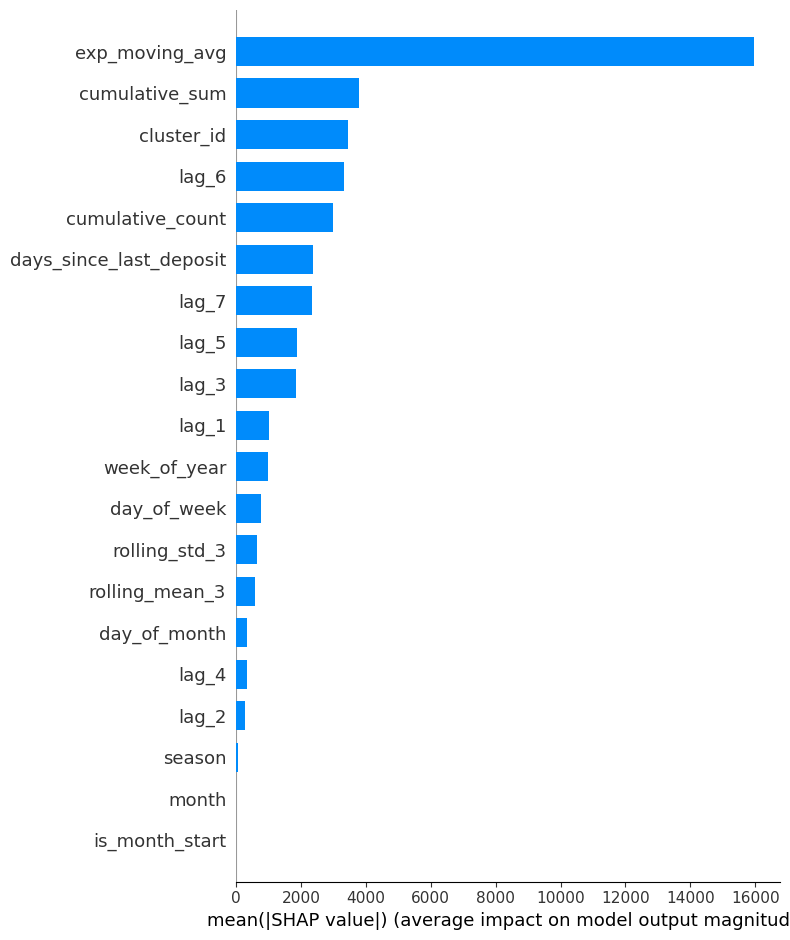

In [434]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

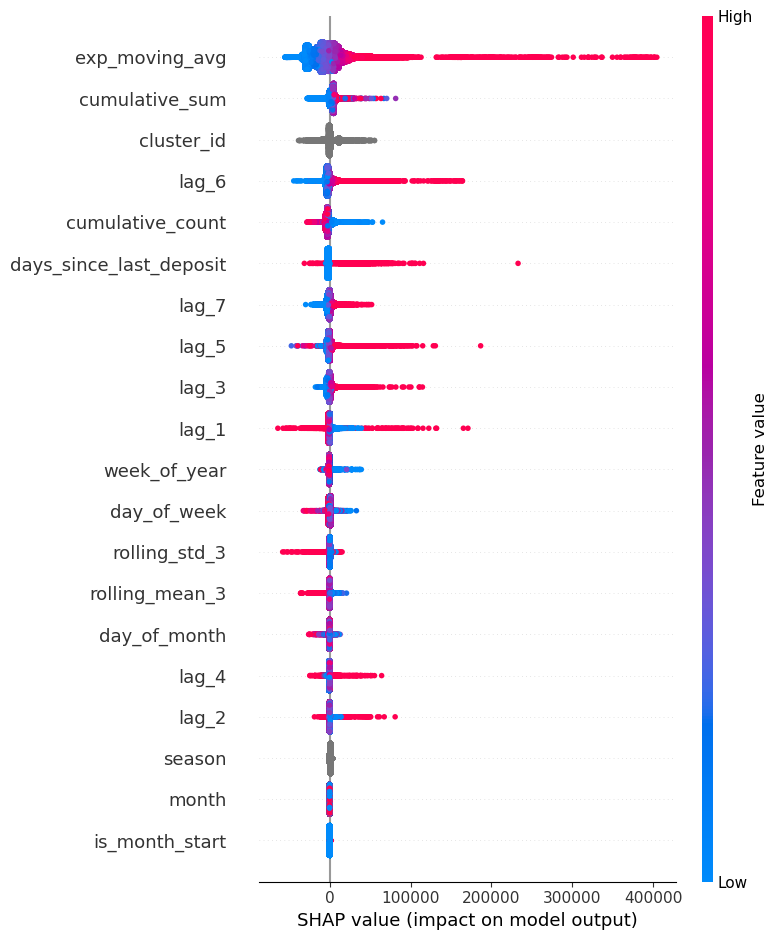

In [439]:
shap.summary_plot(shap_values, X_shap)

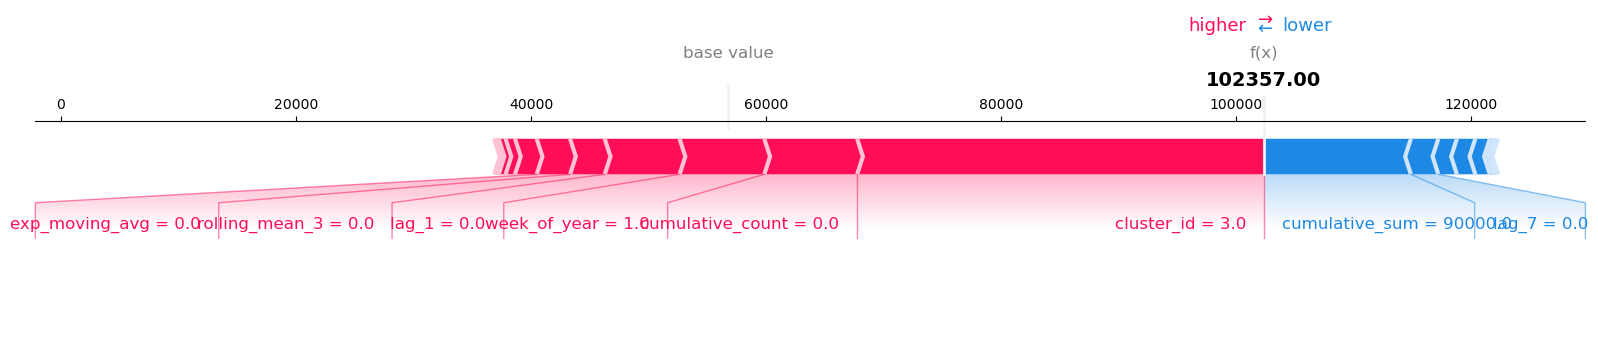

In [441]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_shap.iloc[0],
    matplotlib=True
)

## 🧠 Интерпретация модели на основе важности признаков

Мы проанализировали работу модели и определили, **какие факторы сильнее всего влияют на прогнозы внесений**. Это важно для того, чтобы понимать логику модели и использовать её выводы в бизнесе.

### 📊 Основные факторы, влияющие на предсказания:

1. **Скользящее среднее (`exp_moving_avg`)**  
   Модель активно опирается на "поведение в прошлом". Если в последние дни наблюдался рост активности — модель прогнозирует повышение и дальше.

2. **Лаги (`lag_6`, `lag_5`, и др.)**  
   Количество внесений 5–7 дней назад влияет на прогноз. Это говорит о том, что модель улавливает **недельные циклы** активности.

3. **Поведенческий тип терминала (`cluster_id`)**  
   Модель различает типы терминалов (часто используемые, редкие и т.д.) и строит прогноз по-разному для каждого. Это повышает точность и реализм.

4. **Накопленные метрики (`cumulative_sum`, `days_since_last_deposit`)**  
   Если терминал давно не использовался или в нём накапливалось много наличности — это влияет на решение модели. Модель предсказывает "откат" или спад после всплесков.

5. **Календарные признаки (`week_of_year`, `day_of_week`)**  
   Модель учитывает, **в какой день недели и недели года** мы находимся. Это помогает ловить закономерности: пятничные пики, активность в конце месяца и т.д.

---

### 💡 Почему это важно для бизнеса:

- Модель не просто "угадывает", а **опирается на логичные поведенческие и временные факторы**
- Позволяет объяснить, **почему прогноз именно такой** — это критично для доверия и внедрения
- Данные о влиянии признаков можно использовать для **ручной корректировки прогноза** или построения дополнительных бизнес-правил

> 📌 Вывод: модель не является «чёрным ящиком» — она работает по понятной логике и принимает обоснованные решения на основе реальных данных.